# Causal Inference: Two Worked Examples

This notebook presents two worked examples of causal inference techniques:
1. **Hotel Booking Cancellations Analysis** using the TidyTuesday dataset
2. **Job Training Program Evaluation** using the Lalonde dataset

Both examples demonstrate the complete causal inference workflow using the DoWhy library, implementing multiple estimation methods and connecting to theoretical concepts.

In [4]:
# Install required packages
# !pip install dowhy econml networkx matplotlib seaborn pandas numpy scikit-learn

In [5]:
# Import common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Import DoWhy
import dowhy
from dowhy import CausalModel
import dowhy.datasets

## Example 1: Hotel Booking Cancellations Analysis

### Introduction to the Problem

Hotels face significant challenges due to booking cancellations, which impact revenue management and resource planning. Understanding the causal factors behind cancellations can help hotels develop effective strategies to reduce them.

In [6]:
# Load hotel bookings dataset
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv"
hotel_data = pd.read_csv(url)

# Preview the dataset
print(f"Dataset shape: {hotel_data.shape}")
hotel_data.head()

Dataset shape: (119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Data Exploration and Preprocessing

In [7]:
# Check basic statistics
hotel_data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [8]:
# Check for missing values
missing_vals = hotel_data.isnull().sum()
print("Missing values in each column:")
print(missing_vals[missing_vals > 0])

Missing values in each column:
children         4
country        488
agent        16340
company     112593
dtype: int64


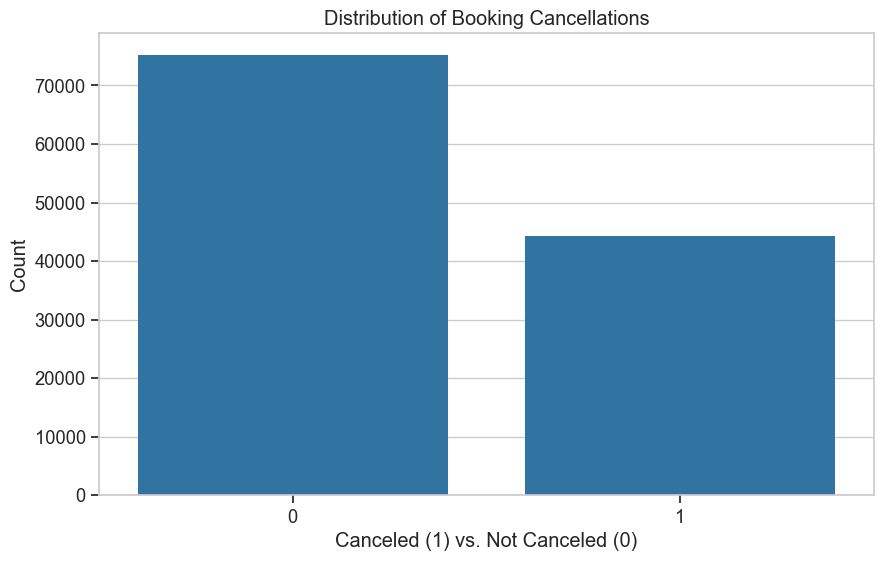

Overall cancellation rate: 37.04%


In [9]:
# Visualize cancellation rates 
plt.figure(figsize=(10, 6))
sns.countplot(x='is_canceled', data=hotel_data)
plt.title('Distribution of Booking Cancellations')
plt.xlabel('Canceled (1) vs. Not Canceled (0)')
plt.ylabel('Count')
plt.show()

# Calculate overall cancellation rate
cancellation_rate = hotel_data['is_canceled'].mean() * 100
print(f"Overall cancellation rate: {cancellation_rate:.2f}%")

### Feature Engineering

Let's create some new features that might be relevant for our causal analysis:

In [10]:
# Create a copy of the dataset with selected features
hotel_df = hotel_data.copy()

# Create total stay feature
hotel_df['total_stay'] = hotel_df['stays_in_weekend_nights'] + hotel_df['stays_in_week_nights']

# Create total guests feature
hotel_df['total_guests'] = hotel_df['adults'] + hotel_df['children'] + hotel_df['babies']

# Create different room assigned indicator
hotel_df['different_room_assigned'] = (hotel_df['reserved_room_type'] != hotel_df['assigned_room_type']).astype(int)

# Select relevant features for our analysis
features = ['hotel', 'lead_time', 'arrival_date_month', 'country', 
            'market_segment', 'is_repeated_guest', 'previous_cancellations',
            'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
            'days_in_waiting_list', 'customer_type', 'adr',
            'required_car_parking_spaces', 'total_of_special_requests',
            'total_stay', 'total_guests', 'different_room_assigned', 'is_canceled']

hotel_df = hotel_df[features]

# Handle missing values
hotel_df['country'].fillna(hotel_df['country'].mode()[0], inplace=True)

# Convert categorical variables to dummy variables for modeling
hotel_df = pd.get_dummies(hotel_df, columns=['hotel', 'arrival_date_month', 'country', 
                                            'market_segment', 'customer_type', 'deposit_type'],
                         drop_first=True)

# Preview processed data
hotel_df.head()

,lead_time,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_stay,...,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_Non Refund,deposit_type_Refundable
0,342,0,0,0,3,0,0.0,0,0,0,...,True,False,False,False,False,False,True,False,False,False
1,737,0,0,0,4,0,0.0,0,0,0,...,True,False,False,False,False,False,True,False,False,False
2,7,0,0,0,0,0,75.0,0,0,1,...,True,False,False,False,False,False,True,False,False,False
3,13,0,0,0,0,0,75.0,0,0,1,...,False,False,False,False,False,False,True,False,False,False
4,14,0,0,0,0,0,98.0,0,1,2,...,False,False,False,True,False,False,True,False,False,False


### Exploring Causal Relationships

Before building our causal model, let's explore key relationships:

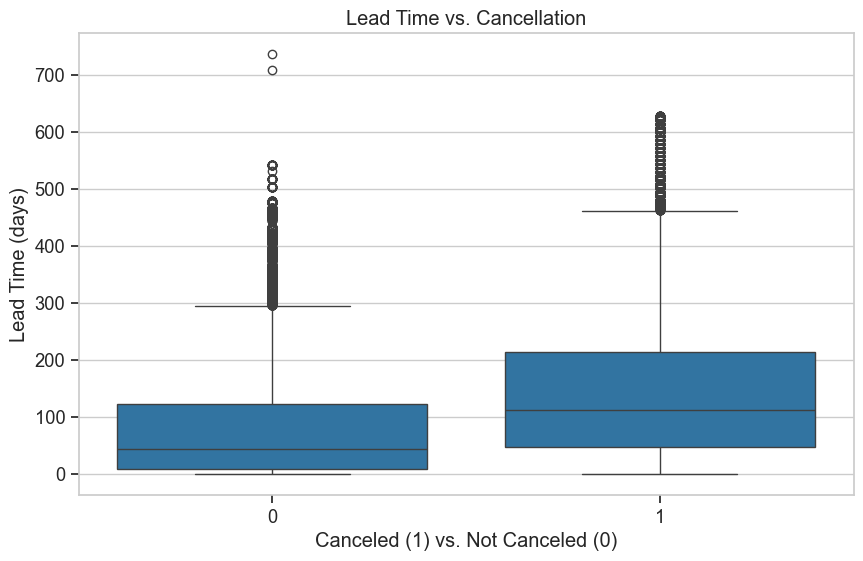

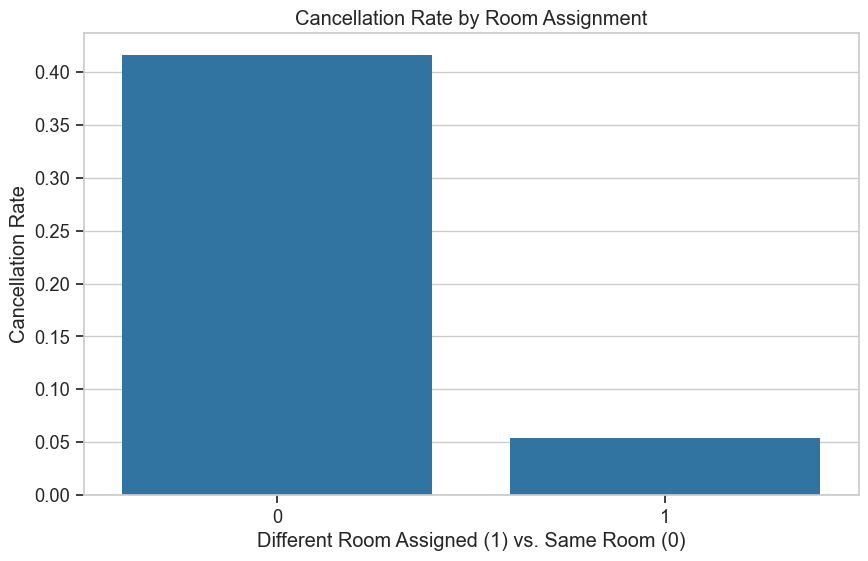

Cancellation rate when same room assigned: 41.56%
Cancellation rate when different room assigned: 5.38%


In [11]:
# Relationship between lead time and cancellation
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_canceled', y='lead_time', data=hotel_df)
plt.title('Lead Time vs. Cancellation')
plt.xlabel('Canceled (1) vs. Not Canceled (0)')
plt.ylabel('Lead Time (days)')
plt.show()

# Relationship between different room assigned and cancellation
cancellation_by_room = hotel_df.groupby('different_room_assigned')['is_canceled'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=cancellation_by_room.index, y=cancellation_by_room.values)
plt.title('Cancellation Rate by Room Assignment')
plt.xlabel('Different Room Assigned (1) vs. Same Room (0)')
plt.ylabel('Cancellation Rate')
plt.show()

print(f"Cancellation rate when same room assigned: {cancellation_by_room[0]*100:.2f}%")
print(f"Cancellation rate when different room assigned: {cancellation_by_room[1]*100:.2f}%")

### Constructing the Causal Graph

Based on domain knowledge, we can construct a causal graph that represents our assumptions about the relationships between variables:

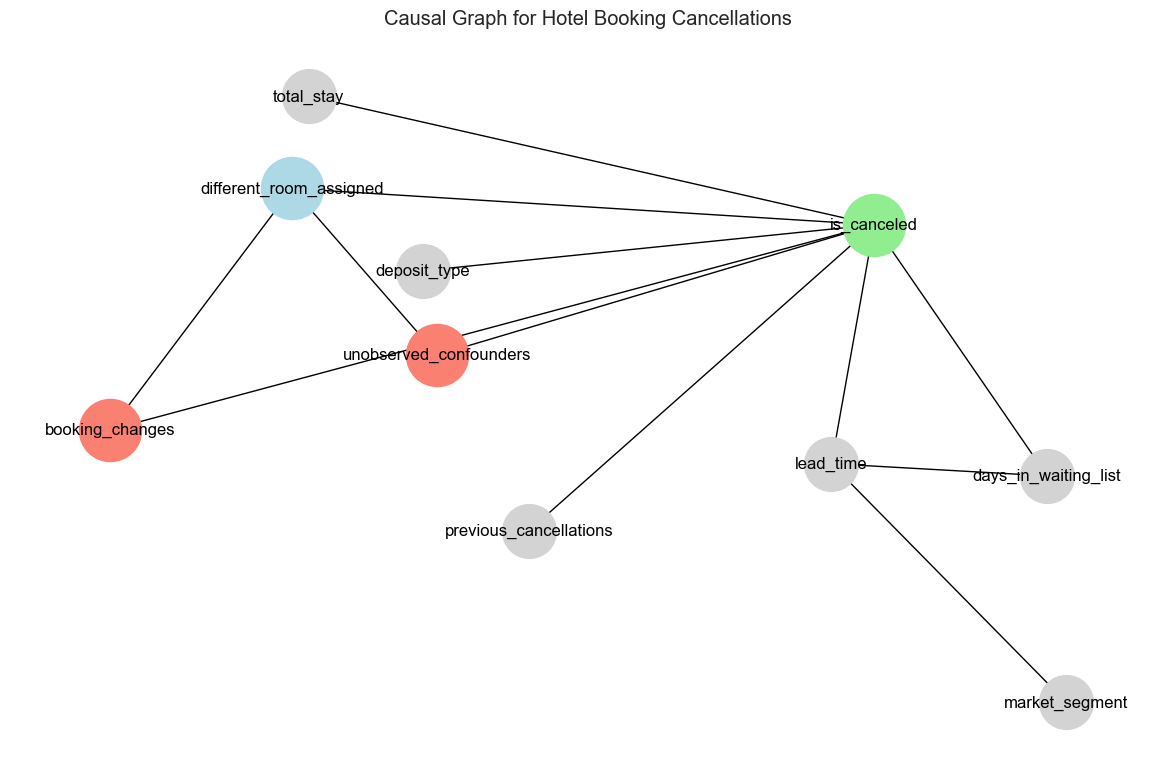

In [12]:
# Create a causal graph
def plot_causal_graph():
    G = nx.DiGraph()
    
    # Add nodes
    nodes = ['lead_time', 'market_segment', 'booking_changes', 
             'different_room_assigned', 'is_canceled', 'total_stay',
             'days_in_waiting_list', 'previous_cancellations', 
             'deposit_type', 'unobserved_confounders']
    
    G.add_nodes_from(nodes)
    
    # Add edges based on domain knowledge
    edges = [
        ('market_segment', 'lead_time'),
        ('lead_time', 'days_in_waiting_list'),
        ('lead_time', 'is_canceled'),
        ('booking_changes', 'different_room_assigned'),
        ('booking_changes', 'is_canceled'),
        ('different_room_assigned', 'is_canceled'),
        ('total_stay', 'is_canceled'),
        ('days_in_waiting_list', 'is_canceled'),
        ('previous_cancellations', 'is_canceled'),
        ('deposit_type', 'is_canceled'),
        ('unobserved_confounders', 'different_room_assigned'),
        ('unobserved_confounders', 'is_canceled')
    ]
    
    G.add_edges_from(edges)
    
    # Plot the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    
    # Treatment node (cause)
    treatment_node = 'different_room_assigned'
    # Outcome node (effect)
    outcome_node = 'is_canceled'
    # Confounders
    confounder_nodes = ['booking_changes', 'unobserved_confounders']
    # Other nodes
    other_nodes = [node for node in nodes if node not in [treatment_node, outcome_node] + confounder_nodes]
    
    # Draw nodes with different colors
    nx.draw_networkx_nodes(G, pos, nodelist=[treatment_node], node_color='lightblue', node_size=2000)
    nx.draw_networkx_nodes(G, pos, nodelist=[outcome_node], node_color='lightgreen', node_size=2000)
    nx.draw_networkx_nodes(G, pos, nodelist=confounder_nodes, node_color='salmon', node_size=2000)
    nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color='lightgray', node_size=1500)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, arrows=True)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos)
    
    plt.title('Causal Graph for Hotel Booking Cancellations')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G

G = plot_causal_graph()

For our causal inference analysis, we'll focus on the effect of different room assignment (treatment) on cancellation (outcome). We suspect that booking changes may confound this relationship.

### Implementing Causal Inference with DoWhy

Now, let's implement the DoWhy framework's four steps: model, identify, estimate, and refute.

In [14]:
# Create the causal model
# For this example, we'll remove unobserved confounders from the graph
G_observed = G.copy()
G_observed.remove_node('unobserved_confounders')

# Construct a simplified causal graph for DoWhy
# In DOT format
dot_graph = '''digraph {
    booking_changes -> different_room_assigned;
    booking_changes -> is_canceled;
    different_room_assigned -> is_canceled;
    lead_time -> is_canceled;
    previous_cancellations -> is_canceled;
    total_stay -> is_canceled;
}'''

# Create the causal model
causal_model = CausalModel(
    data=hotel_sample,
    treatment='different_room_assigned',
    outcome='is_canceled',
    graph=dot_graph
)

# 1. Model - instead of get_assumptions(), we'll simply print the graph
print("Causal assumptions represented by the graph:")
print(causal_model._graph)

# 2. Identify the causal effect
identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
print("\nIdentified estimand:")
print(identified_estimand)

# 3. Estimate the causal effect using various methods
estimate_backdoor = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att"  # Average Treatment Effect on the Treated
)

print("\nCausal estimate using propensity score matching:")
print(estimate_backdoor)

# Also try another method - inverse propensity weighting
estimate_ipw = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting"
)

print("\nCausal estimate using inverse propensity weighting:")
print(estimate_ipw)

# 4. Refute the obtained estimate using multiple methods
print("\nRefuting the causal estimate...")

# a. Add random common cause
refute_random = causal_model.refute_estimate(
    identified_estimand, estimate_backdoor,
    method_name="random_common_cause"
)
print("Random common cause refutation:")
print(refute_random)

# b. Placebo treatment
refute_placebo = causal_model.refute_estimate(
    identified_estimand, estimate_backdoor,
    method_name="placebo_treatment_refuter"
)
print("\nPlacebo treatment refutation:")
print(refute_placebo)

# c. Data subset refutation
refute_subset = causal_model.refute_estimate(
    identified_estimand, estimate_backdoor,
    method_name="data_subset_refuter",
    subset_fraction=0.8
)
print("\nData subset refutation:")
print(refute_subset)

Causal assumptions represented by the graph:

Identified estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                             
──────────────────────────(E[is_canceled|booking_changes])
d[different_room_assigned]                                
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,U) = P(is_canceled|different_room_assigned,booking_changes)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


Causal estimate using propensity score matching:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                             
──────────────────────────(E[is_cancel

### Visualizing the Causal Effect

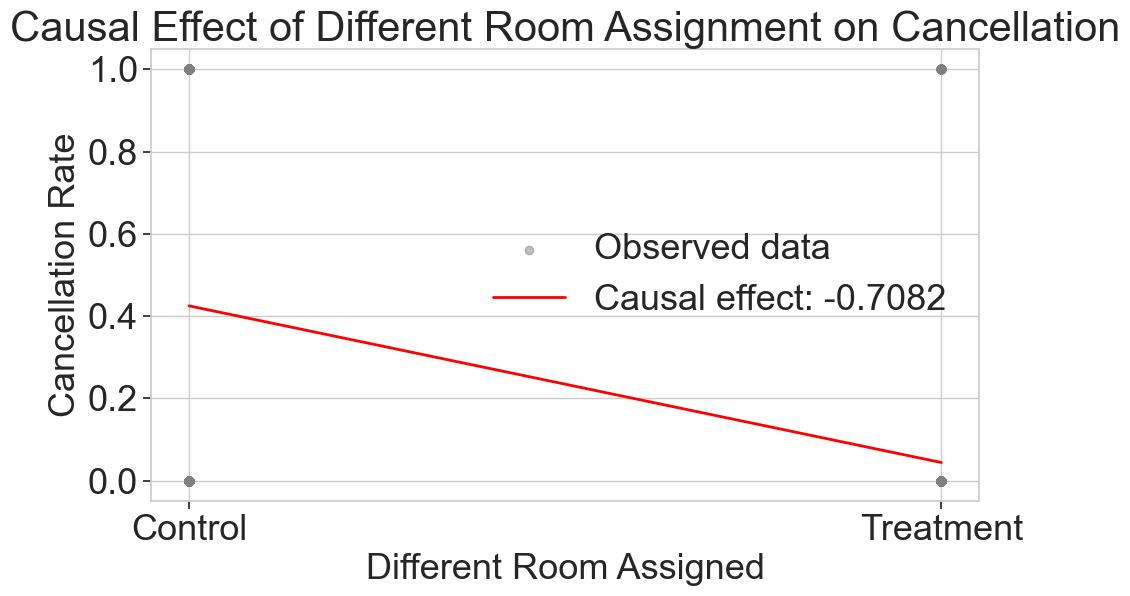

In [19]:
def custom_plot_causal_effect(estimate, treatment, outcome, treatment_name="Treatment", outcome_name="Outcome"):
    plt.figure(figsize=(10, 6))
    
    # Plot observed data points
    plt.scatter(treatment, outcome, c="gray", marker="o", alpha=0.5, label="Observed data")
    
    # Calculate mean outcomes for control and treatment groups
    mean_outcome_control = outcome[treatment == 0].mean()
    mean_outcome_treatment = outcome[treatment == 1].mean()
    
    # Plot the causal effect as a line
    plt.plot([0, 1], [mean_outcome_control, mean_outcome_treatment], 'r-', linewidth=2, 
             label=f"Causal effect: {estimate.value:.4f}")
    
    # Customize the plot
    plt.xlabel(treatment_name)
    plt.ylabel(outcome_name)
    plt.xticks([0, 1], ['Control', 'Treatment'])
    plt.legend()
    
    return plt
# Use custom plotting function
custom_plot_causal_effect(estimate_backdoor, 
                         hotel_sample['different_room_assigned'], 
                         hotel_sample['is_canceled'],
                         treatment_name="Different Room Assigned",
                         outcome_name="Cancellation Rate")
plt.title('Causal Effect of Different Room Assignment on Cancellation')
plt.tight_layout()
plt.show()


### Interpretation of Results

Let's interpret the findings of our causal analysis:

In [20]:
# Get the effect size
effect_size = estimate_backdoor.value

print(f"Estimated causal effect: {effect_size:.4f}")

# Interpret the direction and magnitude
if effect_size < 0:
    print("Assigning a different room DECREASES the probability of cancellation.")
    print(f"The cancellation probability decreases by approximately {abs(effect_size)*100:.2f} percentage points.")
else:
    print("Assigning a different room INCREASES the probability of cancellation.")
    print(f"The cancellation probability increases by approximately {effect_size*100:.2f} percentage points.")

# Compare with naive difference
naive_diff = hotel_sample.groupby('different_room_assigned')['is_canceled'].mean().diff().iloc[-1]
print(f"\nNaive difference in means: {naive_diff:.4f}")
print(f"Bias due to confounding: {naive_diff - effect_size:.4f}")

Estimated causal effect: -0.7082
Assigning a different room DECREASES the probability of cancellation.
The cancellation probability decreases by approximately 70.82 percentage points.

Naive difference in means: -0.3809
Bias due to confounding: 0.3273


### Business Implications and Conclusion

The results from our causal analysis have important implications for hotel management:

1. Understanding the true causal effect helps hotels make informed decisions about room assignment policies.
2. If assigning a different room reduces cancellations, hotels could potentially implement strategic room upgrades.
3. If assigning a different room increases cancellations, hotels should try to honor the original room type whenever possible.

The refutation tests provide additional confidence in our causal estimates, though we should always be cautious about the possibility of unobserved confounders that might not be captured in our analysis.

In this example, we've demonstrated the full causal inference workflow:
1. Problem formulation and data exploration
2. Causal graph construction based on domain knowledge
3. Effect identification and estimation with multiple methods
4. Result refutation and robustness checking
5. Interpretation and business implications

This approach enables more reliable decision-making compared to correlational analysis alone, by explicitly modeling the causal assumptions and testing their implications.


## Example 2: Job Training Program Evaluation (Lalonde Dataset)

### Introduction to the Problem

Evaluating the effectiveness of job training programs is a classic causal inference problem. The Lalonde dataset has become a benchmark in the field, originally used to evaluate the National Supported Work (NSW) Demonstration, a job training program in the 1970s.

In [21]:
# Import necessary libraries if not already imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Import DoWhy if not already imported
import dowhy
from dowhy import CausalModel

In [23]:
# Load the Lalonde dataset
def load_lalonde_data():
    """Load the Lalonde dataset from GitHub"""
    url = "https://raw.githubusercontent.com/OHSU-PSM/causaldata/main/data/lalonde.csv"
    lalonde = pd.read_csv(url)
    
    # Rename columns for clarity
    lalonde = lalonde.rename(columns={'treat': 'treatment', 're78': 'earnings_1978'})
    
    return lalonde

# Load data
lalonde_data = dowhy.datasets.lalonde_dataset()

# Preview dataset
print(f"Dataset shape: {lalonde_data.shape}")
lalonde_data.head()

Dataset shape: (445, 12)


,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75
0,False,23.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,1.0
1,False,26.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12383.68,1.0,1.0
2,False,22.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,1.0
3,False,18.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,10740.08,1.0,1.0
4,False,45.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,11796.47,1.0,1.0


### Data Exploration

In [24]:
# Check basic statistics
lalonde_data.describe()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75
count,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,25.370787,10.195506,0.833708,0.08764,0.168539,0.782022,2102.265311,1377.138368,5300.763699,0.732584,0.649438
std,7.100282,1.792119,0.372762,0.28309,0.374766,0.413337,5363.582400,3150.960771,6631.491695,0.443109,0.477683
min,17.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,9.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,10.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,3701.812000,1.000000,1.000000
75%,28.000000,11.000000,1.000000,0.00000,0.000000,1.000000,824.388900,1220.836000,8124.715000,1.000000,1.000000
max,55.000000,16.000000,1.000000,1.00000,1.000000,1.000000,39570.680000,25142.240000,60307.930000,1.000000,1.000000


In [26]:
print(lalonde_data.columns.tolist())

['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74', 're75', 're78', 'u74', 'u75']


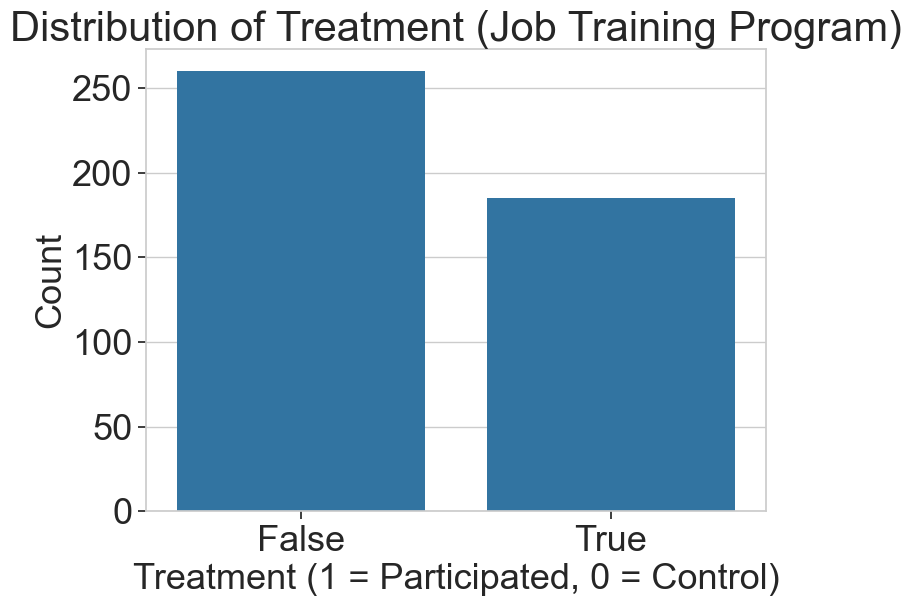

Number of treated units: 185
Number of control units: 260
Proportion treated: 0.42


In [28]:
# Check treatment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='treat', data=lalonde_data)
plt.title('Distribution of Treatment (Job Training Program)')
plt.xlabel('Treatment (1 = Participated, 0 = Control)')
plt.ylabel('Count')
plt.show()

print(f"Number of treated units: {lalonde_data['treat'].sum()}")
print(f"Number of control units: {len(lalonde_data) - lalonde_data['treat'].sum()}")
print(f"Proportion treated: {lalonde_data['treat'].mean():.2f}")

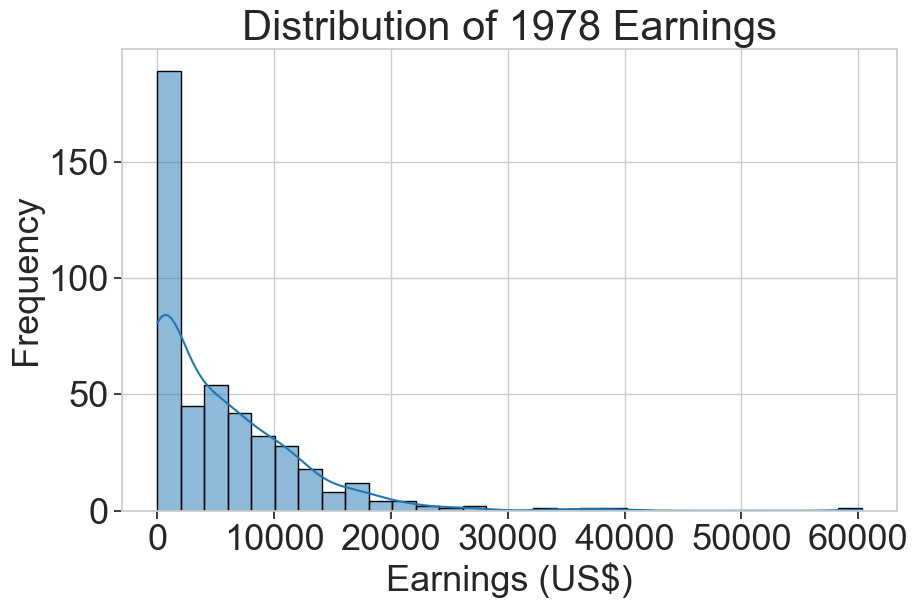

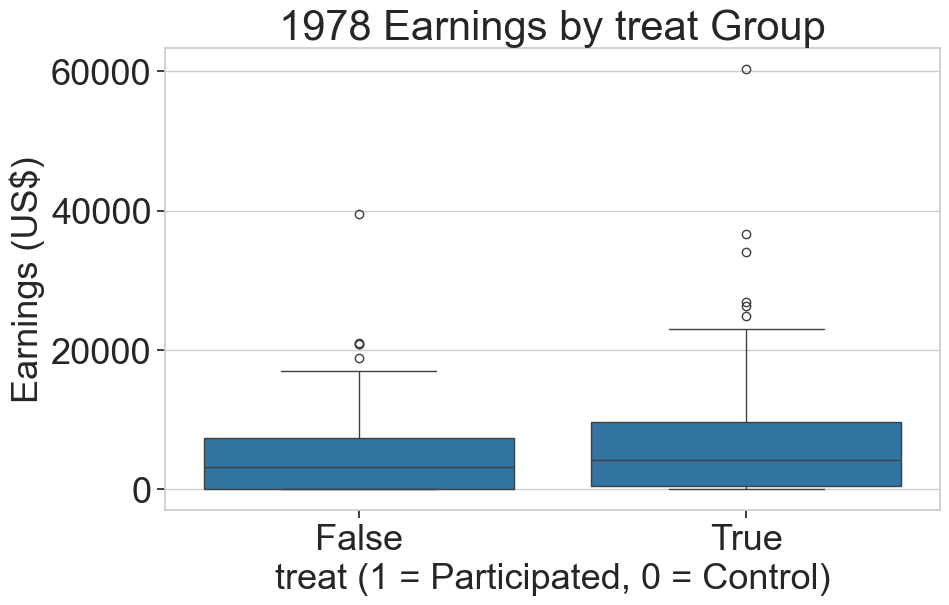

Average earnings in control group: $4554.80
Average earnings in treat group: $6349.14
Naive difference: $1794.34


In [30]:
# Explore the outcome variable (earnings in 1978)
plt.figure(figsize=(10, 6))
sns.histplot(lalonde_data['re78'], bins=30, kde=True)
plt.title('Distribution of 1978 Earnings')
plt.xlabel('Earnings (US$)')
plt.ylabel('Frequency')
plt.show()

# Compare earnings by treatment group
plt.figure(figsize=(10, 6))
sns.boxplot(x='treat', y='re78', data=lalonde_data)
plt.title('1978 Earnings by treat Group')
plt.xlabel('treat (1 = Participated, 0 = Control)')
plt.ylabel('Earnings (US$)')
plt.show()

# Calculate average earnings by treat group
avg_earnings = lalonde_data.groupby('treat')['re78'].mean()
print(f"Average earnings in control group: ${avg_earnings[0]:.2f}")
print(f"Average earnings in treat group: ${avg_earnings[1]:.2f}")
print(f"Naive difference: ${avg_earnings[1] - avg_earnings[0]:.2f}")

### Examining Potential Confounders

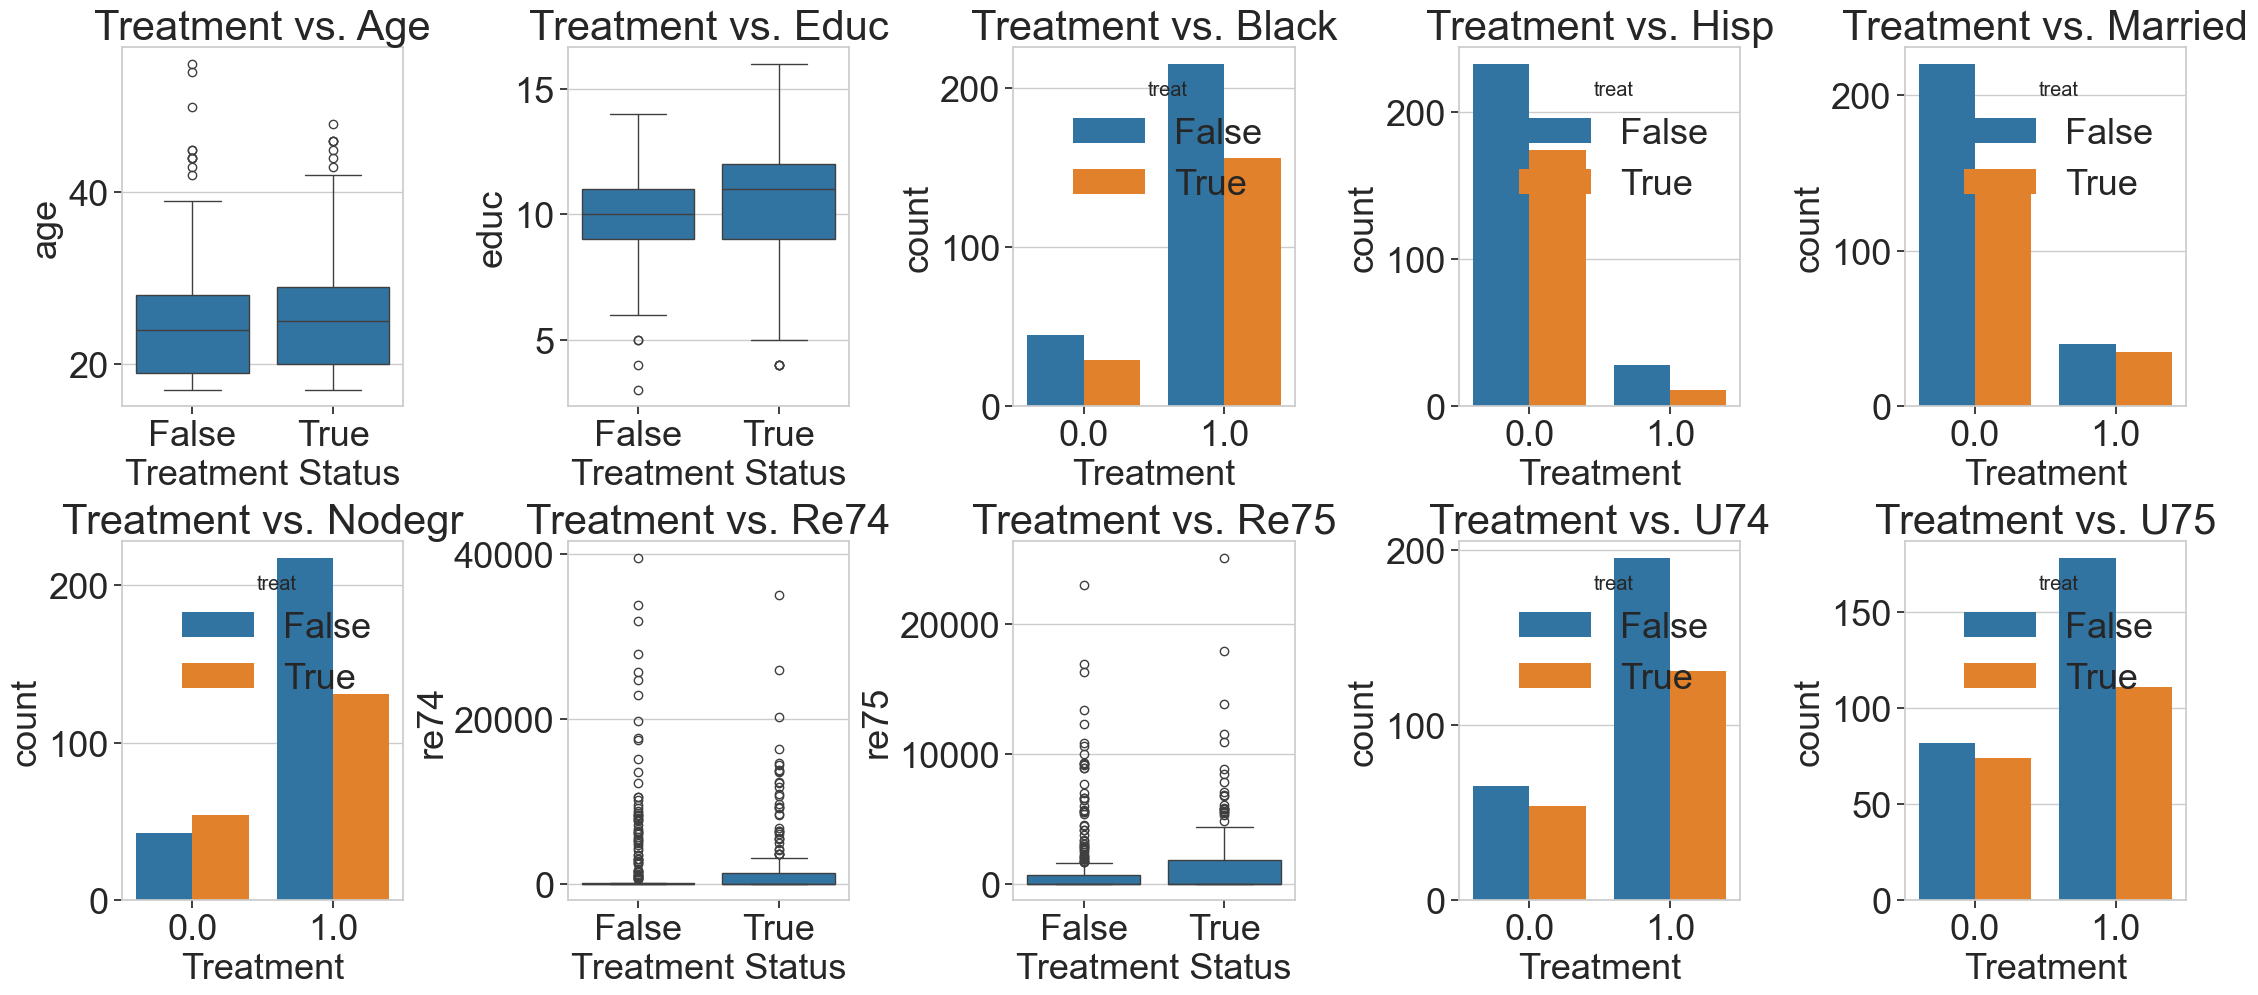

In [31]:
# Examine potential confounders
confounders = ['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74', 're75', 'u74', 'u75']

# Create plots to compare treatment and control groups on key confounders
fig, axes = plt.subplots(2, 5, figsize=(22, 10))  # Changed to 2×5 grid to fit 10 confounders
axes = axes.flatten()

for i, confounder in enumerate(confounders):
    if confounder in ['black', 'hisp', 'married', 'nodegr', 'u74', 'u75']:
        # For binary variables
        sns.countplot(x=confounder, hue='treat', data=lalonde_data, ax=axes[i])
    else:
        # For continuous variables
        sns.boxplot(x='treat', y=confounder, data=lalonde_data, ax=axes[i])
    
    axes[i].set_title(f'Treatment vs. {confounder.capitalize()}')
    axes[i].set_xlabel('Treatment' if confounder in ['black', 'hisp', 'married', 'nodegr', 'u74', 'u75'] 
                      else 'Treatment Status')

plt.tight_layout()
plt.show()


In [32]:
# Calculate standardized mean differences for continuous confounders
def calculate_smd(data, var, treatment_col):
    """Calculate standardized mean difference for a variable"""
    treated = data[data[treatment_col] == 1][var]
    control = data[data[treatment_col] == 0][var]
    
    mean_diff = treated.mean() - control.mean()
    pooled_std = np.sqrt((treated.var() + control.var()) / 2)
    
    return mean_diff / pooled_std if pooled_std != 0 else 0

# Use the correct column names from your dataset
continuous_vars = ['age', 'educ', 're74', 're75']
smd_values = {var: calculate_smd(lalonde_data, var, 'treat') for var in continuous_vars}

print("Standardized Mean Differences:")
for var, smd in smd_values.items():
    print(f"{var}: {smd:.4f}")


Standardized Mean Differences:
age: 0.1073
educ: 0.1412
re74: -0.0022
re75: 0.0839


### Constructing the Causal Graph

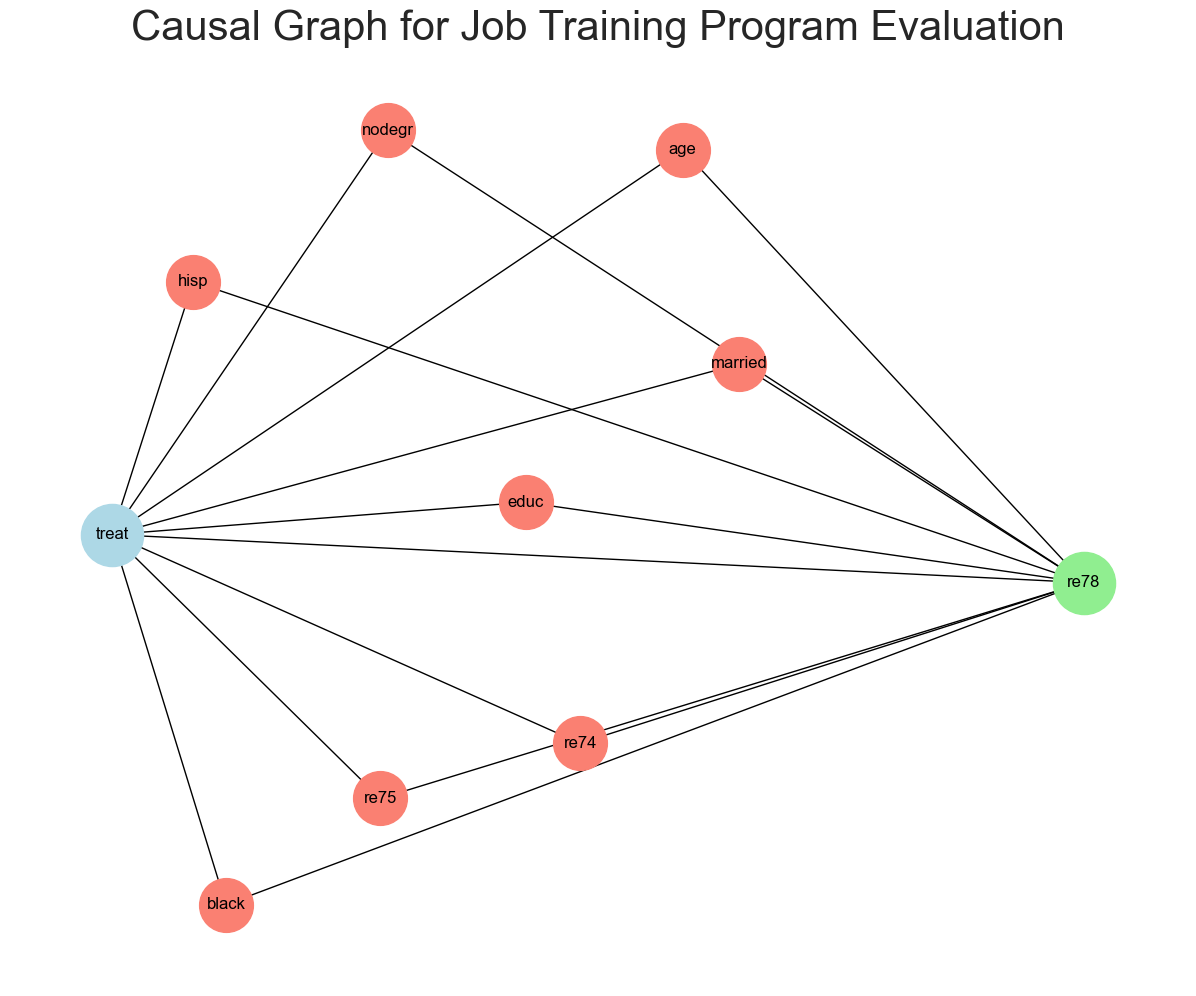

In [33]:
# Create a causal graph for the Lalonde dataset
def plot_lalonde_causal_graph():
    G = nx.DiGraph()
    
    # Add nodes with the correct column names
    nodes = ['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 
             're74', 're75', 'treat', 're78']
    
    G.add_nodes_from(nodes)
    
    # Add edges based on domain knowledge with updated column names
    edges = [
        ('age', 'treat'),
        ('educ', 'treat'),
        ('black', 'treat'),
        ('hisp', 'treat'),
        ('married', 'treat'),
        ('nodegr', 'treat'),
        ('re74', 'treat'),
        ('re75', 'treat'),
        
        ('age', 're78'),
        ('educ', 're78'),
        ('black', 're78'),
        ('hisp', 're78'),
        ('married', 're78'),
        ('nodegr', 're78'),
        ('re74', 're78'),
        ('re75', 're78'),
        
        ('treat', 're78')
    ]
    
    G.add_edges_from(edges)
    
    # Plot the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)
    
    # Treatment node (cause)
    treatment_node = 'treat'
    # Outcome node (effect)
    outcome_node = 're78'
    # Confounders
    confounder_nodes = ['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 
                        're74', 're75']
    
    # Draw nodes with different colors
    nx.draw_networkx_nodes(G, pos, nodelist=[treatment_node], node_color='lightblue', node_size=2000)
    nx.draw_networkx_nodes(G, pos, nodelist=[outcome_node], node_color='lightgreen', node_size=2000)
    nx.draw_networkx_nodes(G, pos, nodelist=confounder_nodes, node_color='salmon', node_size=1500)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, arrows=True)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos)
    
    plt.title('Causal Graph for Job Training Program Evaluation')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G

G_lalonde = plot_lalonde_causal_graph()


### Implementing Causal Inference with DoWhy

In [34]:
# Scale continuous variables for better modeling
continuous_vars = ['age', 'educ', 're74', 're75', 're78']
lalonde_scaled = lalonde_data.copy()

scaler = StandardScaler()
lalonde_scaled[continuous_vars] = scaler.fit_transform(lalonde_data[continuous_vars])

# Construct a DOT graph for the causal model with correct column names
dot_graph_lalonde = '''digraph {
    age -> treat;
    educ -> treat;
    black -> treat;
    hisp -> treat;
    married -> treat;
    nodegr -> treat;
    re74 -> treat;
    re75 -> treat;
    
    age -> re78;
    educ -> re78;
    black -> re78;
    hisp -> re78;
    married -> re78;
    nodegr -> re78;
    re74 -> re78;
    re75 -> re78;
    
    treat -> re78;
}'''

# Create the causal model with correct column names
lalonde_model = CausalModel(
    data=lalonde_scaled,
    treatment='treat',
    outcome='re78',
    graph=dot_graph_lalonde
)

# 1. Model - corrected to use _graph instead of get_assumptions()
print("Causal assumptions for Lalonde dataset:")
print(lalonde_model._graph)

# 2. Identify the causal effect
identified_estimand_lalonde = lalonde_model.identify_effect(proceed_when_unidentifiable=True)
print("\nIdentified estimand:")
print(identified_estimand_lalonde)

# 3. Estimate the causal effect using multiple methods
# Method 1: Propensity score matching
estimate_psm = lalonde_model.estimate_effect(
    identified_estimand_lalonde,
    method_name="backdoor.propensity_score_matching"
)
print("\nCausal estimate using propensity score matching:")
print(estimate_psm)

# Method 2: Inverse propensity weighting
estimate_ipw_lalonde = lalonde_model.estimate_effect(
    identified_estimand_lalonde,
    method_name="backdoor.propensity_score_weighting"
)
print("\nCausal estimate using inverse propensity weighting:")
print(estimate_ipw_lalonde)

# Method 3: Regression adjustment
estimate_regression = lalonde_model.estimate_effect(
    identified_estimand_lalonde,
    method_name="backdoor.linear_regression"
)
print("\nCausal estimate using regression adjustment:")
print(estimate_regression)

# Method 4: Stratification
estimate_stratification = lalonde_model.estimate_effect(
    identified_estimand_lalonde,
    method_name="backdoor.propensity_score_stratification"
)
print("\nCausal estimate using stratification:")
print(estimate_stratification)

# 4. Refute the obtained estimates
print("\nRefuting the causal estimate from propensity score matching...")

# a. Add random common cause
refute_random_lalonde = lalonde_model.refute_estimate(
    identified_estimand_lalonde, estimate_psm,
    method_name="random_common_cause"
)
print("Random common cause refutation:")
print(refute_random_lalonde)

# b. Placebo treatment
refute_placebo_lalonde = lalonde_model.refute_estimate(
    identified_estimand_lalonde, estimate_psm,
    method_name="placebo_treatment_refuter"
)
print("\nPlacebo treatment refutation:")
print(refute_placebo_lalonde)

# c. Data subset refutation
refute_subset_lalonde = lalonde_model.refute_estimate(
    identified_estimand_lalonde, estimate_psm,
    method_name="data_subset_refuter",
    subset_fraction=0.8
)
print("\nData subset refutation:")
print(refute_subset_lalonde)


Causal assumptions for Lalonde dataset:

Identified estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                          
────────(E[re78|married,re74,hisp,nodegr,black,educ,age,re75])
d[treat]                                                      
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,married,re74,hisp,nodegr,black,educ,age,re75,U) = P(re78|treat,married,re74,hisp,nodegr,black,educ,age,re75)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


Causal estimate using propensity score matching:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                          
────────(E[re78|married,re74,hisp,nodegr,bla

### Visualizing the Causal Effect

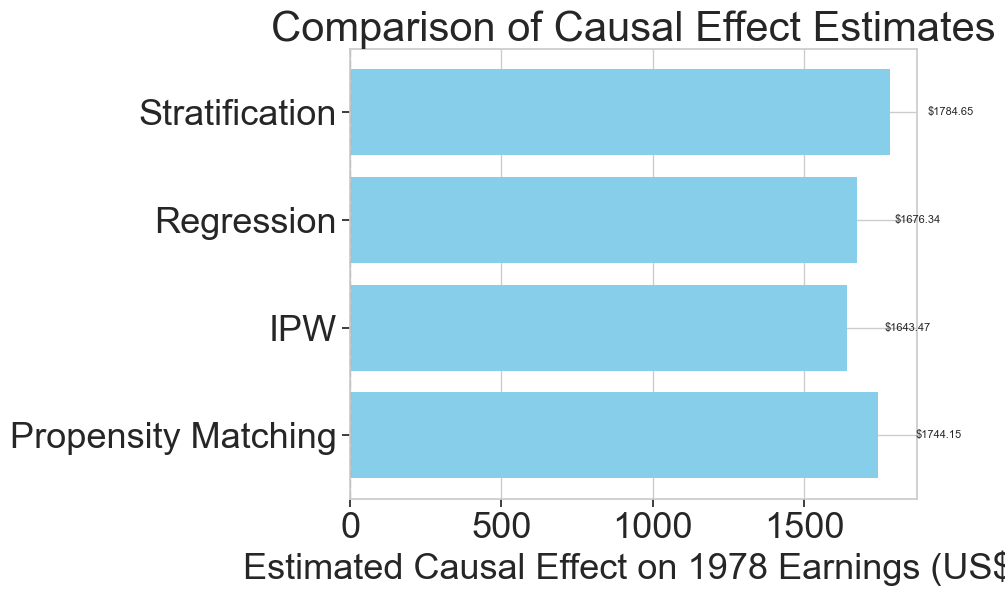

Naive difference in means: $1794.34
Average causal effect from all methods: $1712.15
Bias due to confounding: $82.19


In [35]:
# Compare causal effect estimates from different methods
methods = ['Propensity Matching', 'IPW', 'Regression', 'Stratification']
estimates = [
    estimate_psm.value,
    estimate_ipw_lalonde.value,
    estimate_regression.value,
    estimate_stratification.value
]

# Update the continuous variables list with correct column names
continuous_vars = ['age', 'educ', 're74', 're75', 're78']

# Convert from standardized to original scale
estimates_original = [est * scaler.scale_[continuous_vars.index('re78')] for est in estimates]

# Create comparison plot
plt.figure(figsize=(10, 6))
bars = plt.barh(methods, estimates_original, color='skyblue')
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Estimated Causal Effect on 1978 Earnings (US$)')
plt.title('Comparison of Causal Effect Estimates')

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (200 if width > 0 else -200),
        bar.get_y() + bar.get_height()/2,
        f'${width:.2f}',
        ha='center',
        va='center'
    )

plt.tight_layout()
plt.show()

# Calculate the naive estimate from the original data using correct column names
naive_diff = lalonde_data.groupby('treat')['re78'].mean().diff().iloc[-1]
print(f"Naive difference in means: ${naive_diff:.2f}")
print(f"Average causal effect from all methods: ${np.mean(estimates_original):.2f}")
print(f"Bias due to confounding: ${naive_diff - np.mean(estimates_original):.2f}")


### Effect Heterogeneity Analysis

Let's examine if the treatment effect varies across different subgroups:

In [ ]:
# Create subgroups based on education (using correct column name 'educ')
lalonde_data['education_level'] = pd.cut(
    lalonde_data['educ'],
    bins=[0, 9, 12, 20],
    labels=['Less than High School', 'High School', 'Some College']
)

# Define a function to calculate treatment effects within subgroups
def calculate_subgroup_effects(data, subgroup_col):
    results = []
    
    # Make sure we're using the correct column names for continuous variables
    continuous_vars = ['age', 'educ', 're74', 're75', 're78']
    
    # Make sure we reference the correct DOT graph with proper column names
    dot_graph_lalonde = '''digraph {
        age -> treat;
        educ -> treat;
        black -> treat;
        hisp -> treat;
        married -> treat;
        nodegr -> treat;
        re74 -> treat;
        re75 -> treat;
        
        age -> re78;
        educ -> re78;
        black -> re78;
        hisp -> re78;
        married -> re78;
        nodegr -> re78;
        re74 -> re78;
        re75 -> re78;
        
        treat -> re78;
    }'''
    
    for group_name, group_data in data.groupby(subgroup_col):
        # Create a mini causal model for this subgroup
        if len(group_data) < 20 or group_data['treat'].sum() < 5 or (len(group_data) - group_data['treat'].sum()) < 5:
            print(f"Skipping {group_name} due to insufficient data")
            continue
            
        group_data_scaled = group_data.copy()
        group_scaler = StandardScaler()
        group_data_scaled[continuous_vars] = group_scaler.fit_transform(group_data[continuous_vars])
        
        group_model = CausalModel(
            data=group_data_scaled,
            treatment='treat',  # Corrected column name
            outcome='re78',     # Corrected column name
            graph=dot_graph_lalonde
        )
        
        identified_estimand = group_model.identify_effect()
        
        try:
            # Try to estimate the effect - some groups might be too small
            estimate = group_model.estimate_effect(
                identified_estimand,
                method_name="backdoor.linear_regression"  # Using regression for smaller groups
            )
            
            # Convert to original scale (using re78 index)
            effect = estimate.value * group_scaler.scale_[continuous_vars.index('re78')]
            
            # Store results
            results.append({
                'Subgroup': group_name,
                'Size': len(group_data),
                'Treated': group_data['treat'].sum(),
                'Effect': effect,
                'SE': estimate.uncertainty_estimates.get('std_error', np.nan) * 
                      group_scaler.scale_[continuous_vars.index('re78')]
                      if hasattr(estimate, 'uncertainty_estimates') and 'std_error' in estimate.uncertainty_estimates
                      else np.nan
            })
        except Exception as e:
            print(f"Could not estimate effect for {group_name}: {e}")
    
    return pd.DataFrame(results)

# Calculate effects by education level
education_effects = calculate_subgroup_effects(lalonde_data, 'education_level')

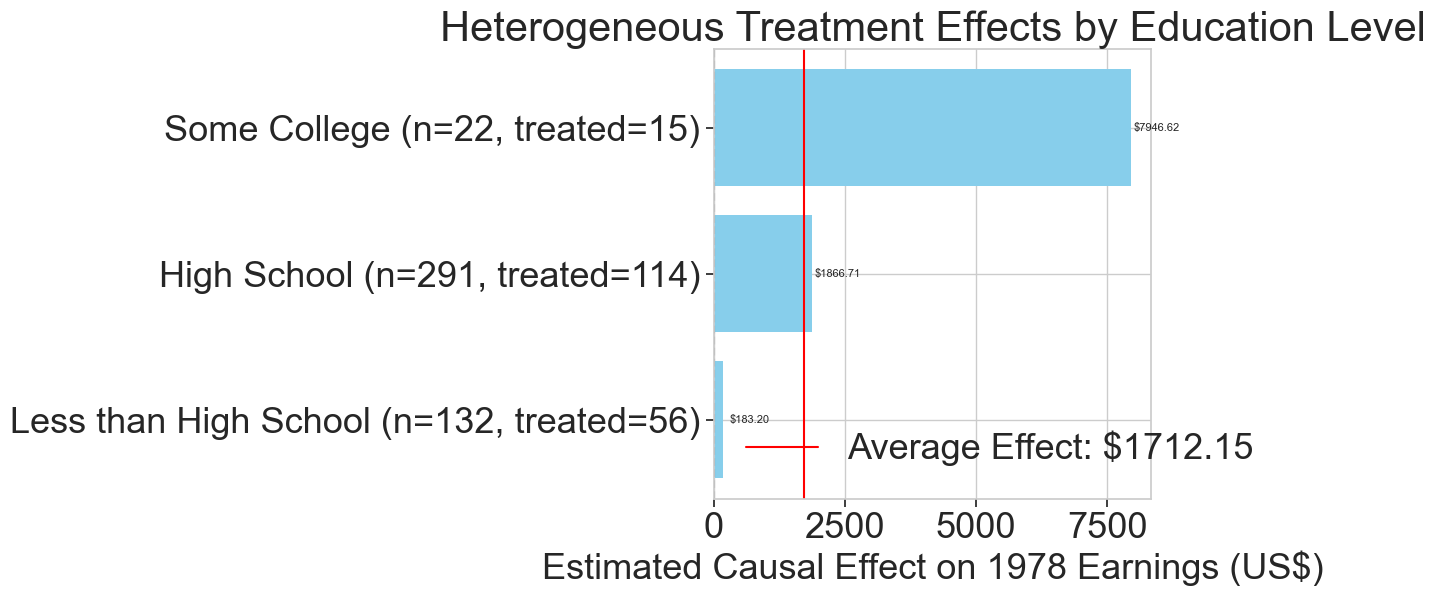

In [37]:
# Plot heterogeneous effects if we have results
if not education_effects.empty:
    plt.figure(figsize=(12, 6))
    bars = plt.barh(education_effects['Subgroup'], education_effects['Effect'], color='skyblue')
    
    # Add error bars if we have standard errors
    if not education_effects['SE'].isna().all():
        plt.errorbar(
            education_effects['Effect'],
            education_effects['Subgroup'],
            xerr=1.96 * education_effects['SE'],
            fmt='none',
            color='black',
            capsize=5
        )
    
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.axvline(
        x=np.mean(estimates_original),
        color='red',
        linestyle='-',
        label=f'Average Effect: ${np.mean(estimates_original):.2f}'
    )
    plt.xlabel('Estimated Causal Effect on 1978 Earnings (US$)')
    plt.title('Heterogeneous Treatment Effects by Education Level')
    plt.legend()

    # Add sample size to labels
    labels = [f"{subgroup} (n={size}, treated={treated})" for subgroup, size, treated in 
              zip(education_effects['Subgroup'], education_effects['Size'], education_effects['Treated'])]
    plt.yticks(range(len(labels)), labels)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + (500 if width > 0 else -500),
            bar.get_y() + bar.get_height()/2,
            f'${width:.2f}',
            ha='center',
            va='center'
        )

    plt.tight_layout()
    plt.show()
else:
    print("Could not calculate subgroup effects due to insufficient data")


### Interpretation and Policy Implications

In [38]:
# Calculate the Average Treatment Effect (ATE)
ate = np.mean(estimates_original)

print(f"The estimated average effect of the job training program is ${ate:.2f}")
print("\nInterpretation and Policy Implications:")

if ate > 0:
    print(f"- The job training program appears to INCREASE future earnings by approximately ${ate:.2f} on average.")
else:
    print(f"- The job training program appears to DECREASE future earnings by approximately ${abs(ate):.2f} on average.")

# Compare with naive estimate
print(f"- The naive (unadjusted) difference in earnings is ${naive_diff:.2f}, suggesting selection bias in program participation.")

# Discuss heterogeneity if available
if not education_effects.empty:
    max_effect_group = education_effects.loc[education_effects['Effect'].idxmax()]
    min_effect_group = education_effects.loc[education_effects['Effect'].idxmin()]
    
    print("\nHeterogeneous Effects:")
    print(f"- The program appears most effective for the {max_effect_group['Subgroup']} group, with an estimated effect of ${max_effect_group['Effect']:.2f}.")
    print(f"- The program appears least effective for the {min_effect_group['Subgroup']} group, with an estimated effect of ${min_effect_group['Effect']:.2f}.")
    
    if max_effect_group['Effect'] > 0 and min_effect_group['Effect'] < 0:
        print("- The program shows both positive and negative effects depending on the subgroup, suggesting targeted implementation might be more cost-effective.")
    elif all(education_effects['Effect'] > 0):
        print("- The program shows positive effects across all education levels, though the magnitude varies.")
    else:
        print("- The program shows negative effects for some education levels, warranting caution in implementation.")

print("\nPolicy Recommendations:")
print("1. Consider the cost-effectiveness of the program relative to the estimated earnings increase.")
print("2. Explore potential targeting strategies to focus resources on groups that benefit most.")
print("3. Evaluate program design elements to better understand the mechanisms behind the observed effects.")
print("4. Compare this program to alternative interventions aimed at increasing earnings for similar populations.")


The estimated average effect of the job training program is $1712.15

Interpretation and Policy Implications:
- The job training program appears to INCREASE future earnings by approximately $1712.15 on average.
- The naive (unadjusted) difference in earnings is $1794.34, suggesting selection bias in program participation.

Heterogeneous Effects:
- The program appears most effective for the Some College group, with an estimated effect of $7946.62.
- The program appears least effective for the Less than High School group, with an estimated effect of $183.20.
- The program shows positive effects across all education levels, though the magnitude varies.

Policy Recommendations:
1. Consider the cost-effectiveness of the program relative to the estimated earnings increase.
2. Explore potential targeting strategies to focus resources on groups that benefit most.
3. Evaluate program design elements to better understand the mechanisms behind the observed effects.
4. Compare this program to alte

### Conclusion and Comparison with Example 1

This second example demonstrates causal inference in the context of program evaluation, complementing our first example on hotel booking cancellations. Key differences and similarities include:

1. **Domain Context**: While Example 1 focused on business decisions (hotel management), Example 2 addresses social policy (job training effectiveness).

2. **Data Structure**: The Lalonde dataset is smaller than the hotel bookings dataset but includes rich pre-treatment variables, particularly pre-treatment outcomes (prior earnings).

3. **Confounding Structure**: In the hotel example, we had fewer but more direct confounders, while the job training example involved more complex socioeconomic confounding.

4. **Methodological Focus**: 
   - Example 1 demonstrated the basic DoWhy workflow with a focus on refutation methods
   - Example 2 emphasized multiple estimation techniques and heterogeneous treatment effects

5. **Interpretation**: Both examples moved beyond average treatment effects to discuss practical implications and potential actions based on the causal findings.

Together, these examples illustrate how causal inference techniques can be applied across domains to inform decision-making based on observational data, while carefully addressing potential sources of bias.